In [79]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [80]:
import tensorflow as tf

### Global Constans

In [81]:
# Fixed for our Flower classes
NUM_CLASSES = 103

# Fixed for Flower color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'sparse_categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['mse','accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 50

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

### Model

In [82]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [83]:

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE))

# 2nd layer as Dense for n-class classification, i.e., using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [84]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 103)               211047    
Total params: 23,798,759
Trainable params: 211,047
Non-trainable params: 23,587,712
_________________________________________________________________


In [85]:
from tensorflow.python.keras import optimizers

model.compile(optimizer = "adam", loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

### Prepating Data

In [86]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        "/kaggle/input/pytorch-challange-flower-dataset/dataset/train",
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='sparse')

validation_generator = data_generator.flow_from_directory(
        "/kaggle/input/pytorch-challange-flower-dataset/dataset/valid",
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='sparse')



Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.


In [87]:
validation_generator.labels

array([  0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   1,   1,   2,
         2,   2,   2,   2,   2,   3,   3,   3,   3,   3,   4,   4,   4,
         4,   4,   4,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
         6,   6,   6,   6,   6,   7,   7,   7,   7,   7,   8,   9,   9,
         9,   9,   9,   9,   9,  10,  10,  11,  11,  11,  11,  11,  11,
        11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  12,  12,  12,
        12,  12,  12,  12,  12,  12,  12,  12,  13,  13,  13,  13,  14,
        14,  14,  14,  14,  14,  15,  15,  15,  15,  15,  15,  15,  16,
        16,  16,  16,  17,  17,  17,  17,  17,  17,  17,  17,  18,  18,
        18,  18,  18,  18,  18,  18,  18,  18,  18,  18,  19,  19,  19,
        19,  19,  20,  20,  21,  21,  21,  22,  23,  23,  23,  23,  23,
        24,  24,  24,  24,  24,  24,  24,  25,  25,  26,  26,  26,  26,
        26,  26,  26,  26,  26,  26,  27,  27,  28,  28,  28,  29,  29,
        29,  29,  29,  29,  29,  30,  30,  30,  30,  30,  30,  3

In [88]:
# Max number of steps that these generator will have opportunity to process their source content
# len(train_generator) should be 'no. of available train images / BATCH_SIZE_TRAINING'
# len(valid_generator) should be 'no. of available train images / BATCH_SIZE_VALIDATION'
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 66, 50, 17)

### Training

In [89]:
fit_history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        verbose = 1
)


Epoch 1/10
10/10 [==============================] - 19s 2s/step - loss: 4.5365 - mse: 4133.8135 - accuracy: 0.0610 - val_loss: 3.6559 - val_mse: 3887.7161 - val_accuracy: 0.1700
Epoch 2/10
10/10 [==============================] - 14s 1s/step - loss: 3.1297 - mse: 3991.3149 - accuracy: 0.3300 - val_loss: 2.5709 - val_mse: 3908.5415 - val_accuracy: 0.4880
Epoch 3/10
10/10 [==============================] - 13s 1s/step - loss: 2.0682 - mse: 3849.4355 - accuracy: 0.6080 - val_loss: 1.9162 - val_mse: 3842.3516 - val_accuracy: 0.5980
Epoch 4/10
10/10 [==============================] - 14s 1s/step - loss: 1.5755 - mse: 4049.4480 - accuracy: 0.7190 - val_loss: 1.4282 - val_mse: 3904.9294 - val_accuracy: 0.7140
Epoch 5/10
10/10 [==============================] - 13s 1s/step - loss: 1.1742 - mse: 3963.3411 - accuracy: 0.8015 - val_loss: 1.2049 - val_mse: 3967.5991 - val_accuracy: 0.7480
Epoch 6/10
10/10 [==============================] - 13s 1s/step - loss: 0.9384 - mse: 3975.6423 - accuracy: 0.

### Training Metrics

In [99]:
print(fit_history.history.keys())

dict_keys(['loss', 'mse', 'accuracy', 'val_loss', 'val_mse', 'val_accuracy'])


In [113]:
for metric in LOSS_METRICS:
    print('train', metric, ': ', fit_history.history[metric][-1])
    print('val','val_'+metric, ': ', fit_history.history['val_'+metric][-1])

train mse :  4041.129638671875
val val_mse :  3855.35009765625
train accuracy :  0.9089999794960022
val val_accuracy :  0.8740000128746033


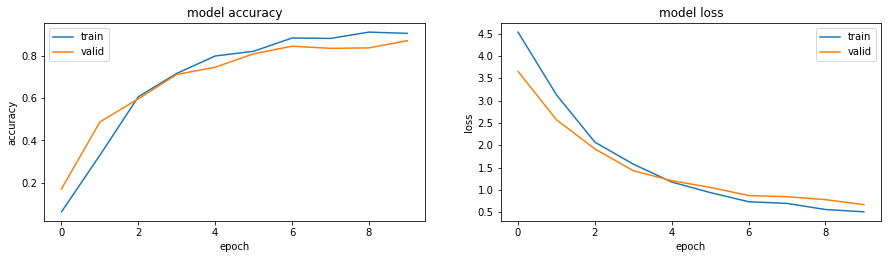

In [102]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

1. ### Evaluating Model

In [103]:
import shutil


#os.mkdir('/kaggle/working/test')
#os.mkdir('/kaggle/working/test/test')

#source_dir = "/kaggle/input/pytorch-challange-flower-dataset/dataset/test"
#destination_dir = "/kaggle/output/test/test/test"
#shutil.copytree(source_dir, destination_dir)

In [104]:
test_generator = data_generator.flow_from_directory(
    directory = "/kaggle/output/test/test",
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = "sparse",
    shuffle = False,
    seed = 123
)


Found 819 images belonging to 1 classes.


In [105]:
print("Evaluate on test data")
results = model.predict(test_generator)
print(results)

Evaluate on test data
[[5.1681578e-05 3.2094339e-04 1.3049062e-04 ... 3.1915840e-06
  1.1300945e-05 6.4124248e-07]
 [9.9401603e-08 5.6248214e-06 1.6339748e-06 ... 9.3192831e-09
  1.0353934e-06 5.2739235e-09]
 [8.4910262e-06 9.9078214e-05 2.9763884e-05 ... 4.5779120e-07
  2.3200912e-06 2.9396227e-07]
 ...
 [1.5538207e-01 1.1085672e-03 3.9131455e-03 ... 8.9083701e-02
  7.0408499e-04 8.0078433e-05]
 [9.9529205e-03 9.7066768e-05 7.4660893e-05 ... 1.4907598e-01
  3.3049772e-03 1.6914011e-04]
 [1.4264031e-02 2.8066698e-04 2.1011767e-03 ... 3.7831530e-02
  6.2617532e-04 9.6129806e-05]]


In [106]:
predictions = []
for line in results:
    predictions.append(np.argmax(line))

In [107]:
df = pd.DataFrame(predictions)
 
# save the dataframe as a csv file
df.to_csv("predictions100.csv")

In [108]:
df

,0
0,77
1,77
2,77
3,77
4,77
...,...
814,55
815,55
816,0
817,83
